In [1]:
# Import all necessary libraries for this example

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DCCSMLM

%matplotlib notebook

In [2]:
only_p = False  # Set this to True if only p (but not m) should be considered -> use Eq. 1

# Load the "CalibrationValues.csv" file which contains colocalization ratios of several experiments in
# a "rate_mVenus" column as well as the known oligomeric state in the "stoichiometry" column
reference = DCCSMLM.DCCReferenceProteins("ExampleData/CalibrationValues.csv", "rate_mVenus", "stoichiometry")

# Run a bootstrap with 10000 resamples and calculate p and m along with their 95% CI
reference.reference_bootstrap(10_000, save_result=True, only_p=only_p)



array([[0.29342653, 0.16632545],
       [0.28094579, 0.15865965],
       [0.25632067, 0.15963622],
       ...,
       [0.18498784, 0.14573746],
       [0.29143428, 0.15937788],
       [0.30412154, 0.16916679]])

Mean m: 0.2985259530157781, 95% CI: 0.20498259369661467 - 0.3877754720990475
Mean p: 0.1654993228143838, 95% CI: 0.15034832105895155 - 0.18112673249434502
R² = 0.9669804242274322


<IPython.core.display.Javascript object>


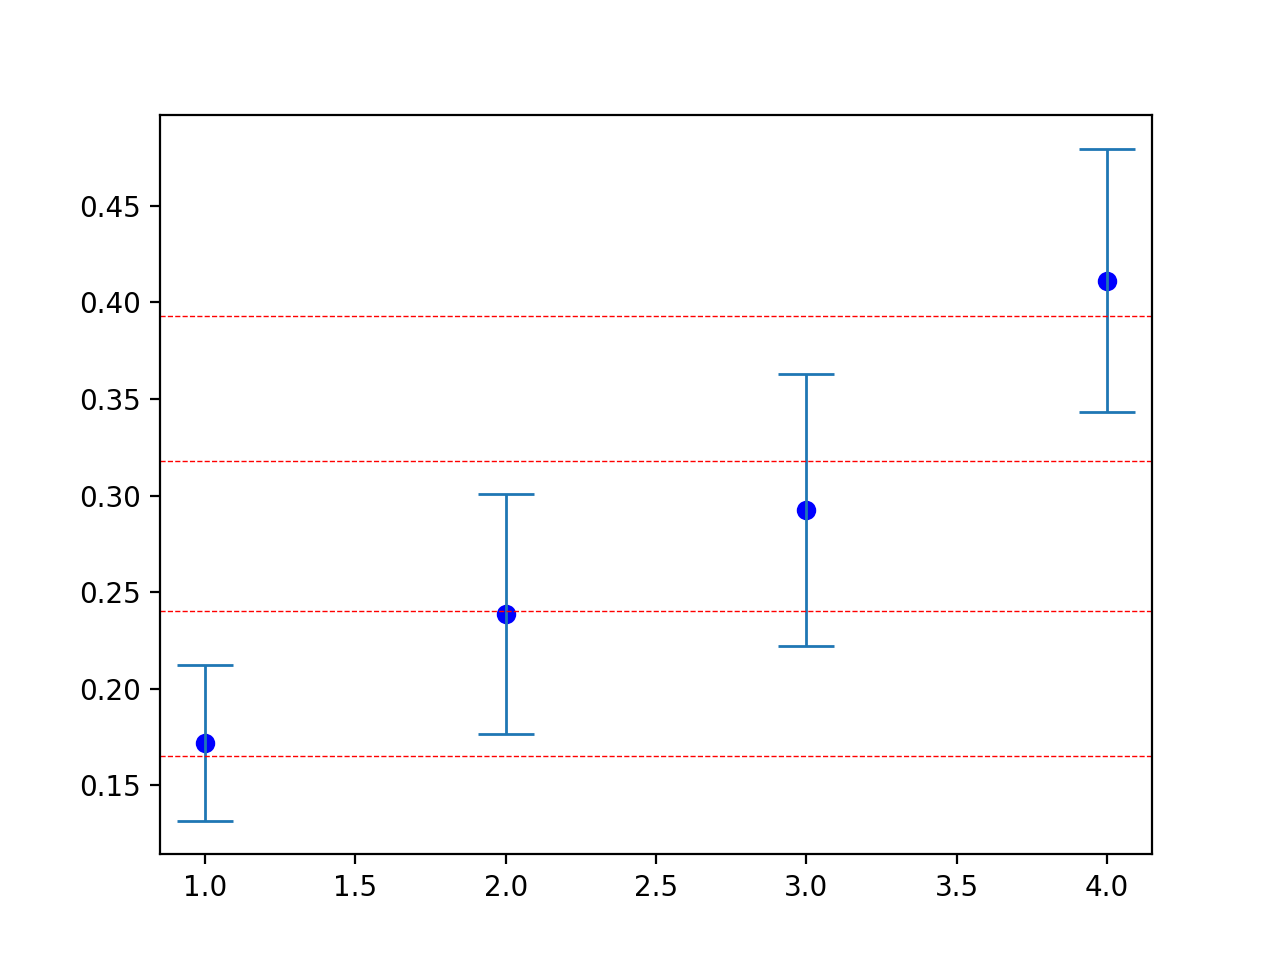

In [3]:
# Print the calculated p and m + 95% CI
print(f"Mean m: {reference.m}, 95% CI: {reference.m_ci[0]} - {reference.m_ci[1]}")
print(f"Mean p: {reference.p}, 95% CI: {reference.p_ci[0]} - {reference.p_ci[1]}")

# Print the r^2 of the fit
corr_matrix = np.corrcoef(reference.reference_mean, reference.E(n=4, only_p=only_p))
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(f"R² = {R_sq}")

# Create a graph of the calibration
plt.figure()
plt.plot(range(1,5), reference.reference_mean, "bo") # Experimentally determined means
# Experimentally determined standard deviations
plt.errorbar(range(1,5), reference.reference_mean, yerr=reference.reference_std, capsize=10, lw=1, fmt="none")
# Horizontal lines indicate expected colocalization values based on the mean values for p and m of the bootstrap
[plt.axhline(e, color="red", ls="--", lw=0.5) for e in reference.E(n=4)]
plt.show()